In [16]:
!pip install transformers torch --quiet



In [29]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. Read data
df = pd.read_csv("tracks_with_emotionLabels.csv")
df = df[df["clean_lyrics"].notna()]
df = df[df["clean_lyrics"].str.len() > 20].reset_index(drop=True)

# 2. Load specialized emotion model
model_name = "j-hartmann/emotion-english-distilroberta-base"

device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")

emotion_classifier = pipeline(
    "text-classification",
    model=model_name,
    tokenizer=model_name,
    return_all_scores=True,
    device=device
)

base_emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]

# 3. Batch analyze emotions of lyrics and map to 5 categories
texts = [str(t)[:512] for t in df["clean_lyrics"].tolist()]  # Truncate a bit to speed up & prevent overly long inputs

results = emotion_classifier(texts, batch_size=16, truncation=True)

happy_scores = []
sad_scores = []
angry_scores = []
relaxed_scores = []
energetic_scores = []
pred_5class = []          # Your desired 5 main emotions
pred_base_emotion = []    # Original model's 7 main emotions (optional)

for res in results:
    # res is a list[{"label": "...", "score": ...}, ...]
    d = {x["label"].lower(): x["score"] for x in res}  # Convert to a dictionary for easy access

    # Ensure each base emotion has a value (treat as 0 if not present)
    for be in base_emotions:
        d.setdefault(be, 0.0)

    # Original model's main emotion (7 classes)
    base_pred = max(d.items(), key=lambda x: x[1])[0]
    pred_base_emotion.append(base_pred)

    # 4. Map to your 5 emotions
    score_happy = d["joy"]
    score_sad = d["sadness"]
    score_angry = d["anger"]
    score_relaxed = d["neutral"]
    # Energetic: surprise + part of joy, representing more excited songs
    score_energetic = 0.6 * d["surprise"] + 0.4 * d["joy"]

    happy_scores.append(score_happy)
    sad_scores.append(score_sad)
    angry_scores.append(score_angry)
    relaxed_scores.append(score_relaxed)
    energetic_scores.append(score_energetic)

    # 5. Select the maximum value from the 5 categories as the main emotion for this song
    scores_5 = {
        "happy": score_happy,
        "sad": score_sad,
        "angry": score_angry,
        "relaxed": score_relaxed,
        "energetic": score_energetic
    }
    pred_5class.append(max(scores_5.items(), key=lambda x: x[1])[0])

# 6. Write back to DataFrame
df["score_happy"] = happy_scores
df["score_sad"] = sad_scores
df["score_angry"] = angry_scores
df["score_relaxed"] = relaxed_scores
df["score_energetic"] = energetic_scores
df["pred_emotion"] = pred_5class            # Your final emotion
df["base_emotion_raw"] = pred_base_emotion  # Original model's 7 emotions (optional)

df.to_csv("track_with_pred.csv", index=False)
print("Saved track_with_pred.csv")
df.head()


Using device: GPU


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Saved track_with_pred.csv


,track_name,artist_name,play_count,lyrics,clean_lyrics,true_emotion,score_happy,score_sad,score_angry,score_relaxed,score_energetic,pred_emotion,base_emotion_raw
0,HUMBLE.,Kendrick Lamar,46574,Nobody pray for me\nIt been that day for me\nW...,nobody pray for me\nit been that day for me\nw...,angry,0.018830,0.084799,0.709492,0.043545,0.049918,angry,anger
1,One Dance,Drake,43447,"Baby, I like your style\n\nGrips on your waist...","baby, i like your style\ngrips on your waist, ...",sad,0.279919,0.446045,0.019362,0.170169,0.145203,sad,sadness
2,Broccoli (feat. Lil Yachty),DRAM,41309,":\nI know you want this for life,\nTaking pict...","i know you want this for life,\ntaking picture...",angry,0.099138,0.118359,0.248219,0.079172,0.065260,angry,fear
3,Closer,The Chainsmokers,41079,"Hey, I was doing just fine before I met you\nI...","hey, i was doing just fine before i met you\ni...",sad,0.012764,0.894916,0.022500,0.018527,0.029887,sad,sadness
4,Congratulations,Post Malone,39987,"Mm-mm\nYeah, yeah\nMm-mm\nYeah (Hey)\n\nMy mam...","mm mm\nyeah, yeah\nmm mm\nyeah\nmy mama called...",relaxed,0.063074,0.116187,0.104724,0.278227,0.124208,relaxed,neutral


Model accuracy on 896 samples: 0.811


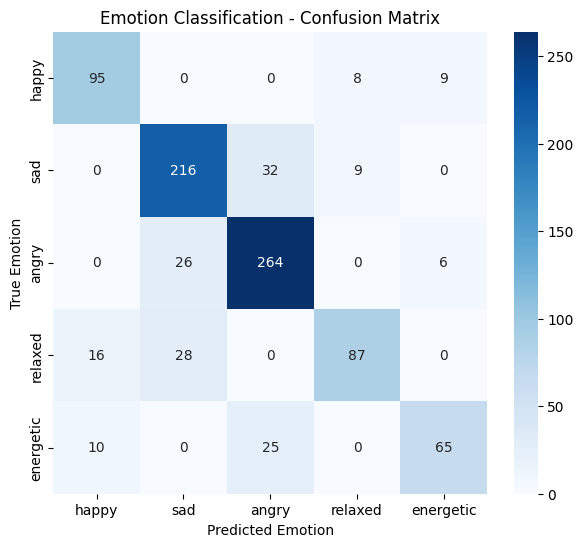

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["happy", "sad", "angry", "relaxed", "energetic"]

y_true = df["true_emotion"]
y_pred = df["pred_emotion"]

# 1. Calculate accuracy
accuracy = (y_true == y_pred).mean()
print(f"Model accuracy on 896 samples: {accuracy:.3f}")

# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Emotion Classification - Confusion Matrix")
plt.show()


In [35]:
df_emotion = pd.read_csv("track_with_pred.csv")

emotion_labels = ["happy", "sad", "angry", "relaxed", "energetic"]
score_cols = [f"score_{lab}" for lab in emotion_labels]


def sample_playlist_with_mood(df, k_min=10, k_max=20, random_state=None):
    import random
    if random_state is not None:
        random.seed(random_state)

    k = random.randint(k_min, k_max)
    playlist = df.sample(n=k, replace=False, random_state=random_state)

    mean_scores = playlist[score_cols].mean()
    dominant_emotion_en = mean_scores.idxmax().replace("score_", "")

    emotion_score_dict = {lab: mean_scores[f"score_{lab}"] for lab in emotion_labels}
    return playlist, dominant_emotion_en, emotion_score_dict

# Try generating a playlist
playlist, mood_en, mood_scores = sample_playlist_with_mood(df_emotion, k_min=10, k_max=20, random_state=None)

print("Playlist dominant emotion:", mood_en)
print("Average score for each emotion:", mood_scores)
print(playlist[["track_name", "artist_name", "pred_emotion"]])


Playlist dominant emotion: angry
Average score for each emotion: {'happy': np.float64(0.1321565441321581), 'sad': np.float64(0.19267660894547584), 'angry': np.float64(0.23094318459334315), 'relaxed': np.float64(0.06558132839563766), 'energetic': np.float64(0.13052785503386982)}
                                   track_name     artist_name pred_emotion
877                 Your Body Is a Wonderland      John Mayer        happy
301                        Turn Down for What        DJ Snake        angry
528           All I Want for Christmas Is You    Mariah Carey          sad
296                             We Found Love         Rihanna          sad
425                                  Sneakin’           Drake        angry
35                             1-800-273-8255           Logic          sad
710  Why'd You Only Call Me When You're High?  Arctic Monkeys        angry
884                               Best Friend      Young Thug        angry
293                                  You & Me 

In [36]:
import random

def recommend_by_last_mood(df, mood_en, playlist=None, n_min=5, n_max=10):
    """
    Recommend 5-10 songs with the same mood based on the previously printed emotion (mood_en).
    If a playlist is provided, it will avoid recommending songs already in the playlist.
    """
    score_col = f"score_{mood_en}"
    n = random.randint(n_min, n_max)

    # First, build a list of songs to exclude (to prevent duplication with the playlist)
    if playlist is not None:
        exclude_tracks = set(playlist["track_name"])
    else:
        exclude_tracks = set()

    # 1) First, filter: pred_emotion is the same as mood_en + not in the original playlist
    candidates = df[
        (df["pred_emotion"] == mood_en) &
        (~df["track_name"].isin(exclude_tracks))
    ].copy()

    # 2) If there are too few songs with the same emotion, relax the criteria and sort only by that emotion's score
    if len(candidates) < n:
        candidates = df[~df["track_name"].isin(exclude_tracks)].copy()

    candidates = candidates.sort_values(by=score_col, ascending=False)

    # Take the top n songs as recommendations
    rec = candidates.head(n)
    return rec

# Actual call: directly use the mood_en printed in your last cell
recommended = recommend_by_last_mood(
    df=df_emotion,
    mood_en=mood_en,        # This is the English emotion printed in your last cell
    playlist=playlist,      # If you don't have a playlist variable, change this parameter to None
    n_min=5,
    n_max=10
)

print(f"Recommended songs based on the previous mood {mood_en}:")
print(recommended[["track_name", "artist_name", "pred_emotion"]])


Recommended songs based on the previous mood angry:
             track_name          artist_name pred_emotion
496               Water             Ugly God        angry
157              Issues       Julia Michaels        angry
847  Where Is The Love?  The Black Eyed Peas        angry
377              Rollin        Calvin Harris        angry
874        Ice Ice Baby          Vanilla Ice        angry
668  Cherry Wine - Live               Hozier        angry
